<a href="https://colab.research.google.com/github/Ved204/CP468-Facial-Recognition/blob/main/colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Facial Emotion Recognition



**Kaggle Dataset :** [https://www.kaggle.com/datasets/shuvoalok/ck-dataset](https://www.kaggle.com/datasets/shuvoalok/ck-dataset)


---



**7 Classes are :**

1. anger
2. contempt
3. disgust
4. fear
5. sadness
6. happy
7. suprise


---



**Pre-Trained Models used in Phase Two :**

1. [VGG16 Model](https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG16)

2. [ResNet50 Model](https://www.tensorflow.org/api_docs/python/tf/keras/applications/ResNet50)

3. [InceptionV3 Model](https://www.tensorflow.org/api_docs/python/tf/keras/applications/InceptionV3)


# Project Configuration

In [361]:
# Import Libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import cv2
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.python.keras.utils.np_utils import to_categorical
from keras.preprocessing.image import load_img
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Input,Activation,Add, BatchNormalization, MaxPool2D
from keras.models import Model
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.applications import VGG16, ResNet50, InceptionV3

from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow

In [362]:
# Mount Drive
from google.colab import drive
import os

drive.mount('/content/drive')
kaggle_json_path = '/content/drive/MyDrive/CP468 Project/kaggle.json'
# %cd '/content/drive/MyDrive/CP468 Project/dataset/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install Dataset --> Not Needed Now (Downloaded on Drive)
# !pip install kaggle
# ! mkdir ~/.kaggle
# ! cp {kaggle_json_path} ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download -d shuvoalok/ck-dataset
# ! unzip ck-dataset.zip

In [238]:
# Define Variables to read folder names as variables
dataset_folder = '/content/drive/MyDrive/CP468 Project/dataset/input/'
output_path= '/content/drive/MyDrive/CP468 Project/dataset/output/'
sub_folders=os.listdir(dataset_folder)

i=0
last=[]
images=[]
labels=[]
original_labels = []
temp = sub_folders

In [ ]:
# Define the original 7 labels
original_label_mapping = {
    0: 'anger', 1: 'contempt', 2: 'disgust', 3: 'fear', 4: 'happy', 5: 'sadness', 6: 'surprise'
}

# Update the label encoding
images = []
labels = []
original_labels = []

for sub_folder in sub_folders:
    sub_folder_index = temp.index(sub_folder)
    label = sub_folder_index
    path = os.path.join(dataset_folder, sub_folder)
    sub_folder_images = os.listdir(path)

    for image in sub_folder_images:
        image_path = path + '/' + image
        print(image_path + "\t" + str(label))
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (48, 48))
        images.append(image)
        labels.append(label)
        original_labels.append(label)

# Phase 1: Building a CNN from Scratch

Preprocess Data

In [364]:
# Preprocess Data
images_x = np.array(images)
labels_y = np.array(labels)
images_x = images_x / 255

# Encode Labels
num_of_classes = 7
labels_y_encoded = tf.keras.utils.to_categorical(labels_y, num_classes=num_of_classes)

In [365]:
# Split Dataset in 75% for Training and 25% for Testing
X_train, X_test, Y_train, Y_test = train_test_split(images_x, labels_y_encoded, test_size=0.25, random_state=10)

Data Analysis

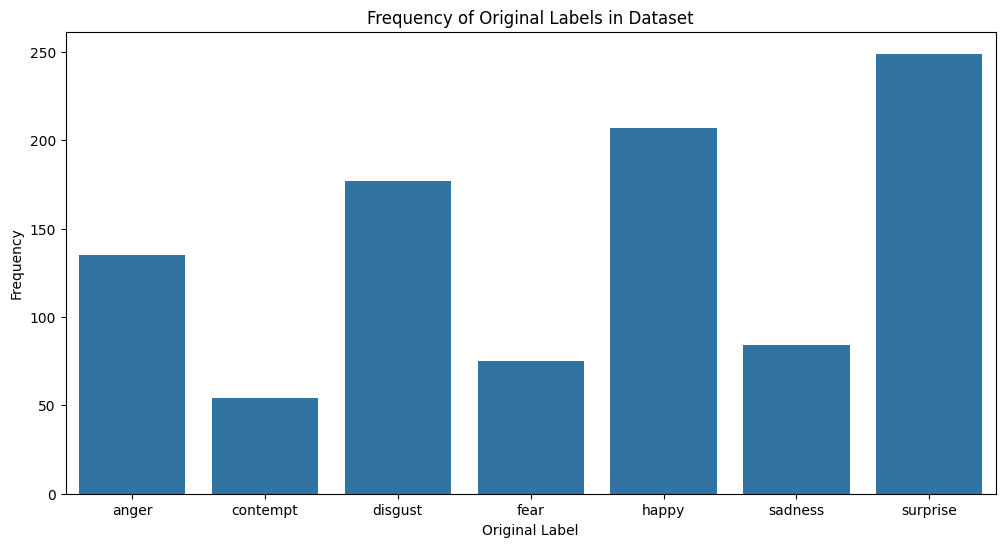

In [366]:
# Update the original label mapping for plotting
original_labels_mapped = [original_label_mapping[label] for label in original_labels]
original_labels_df = pd.DataFrame({'original_label': original_labels_mapped})

# Plot the frequency of original labels
plt.figure(figsize=(12, 6))
sns.countplot(x='original_label', data=original_labels_df, order=list(original_label_mapping.values()))
plt.title('Frequency of Original Labels in Dataset')
plt.xlabel('Original Label')
plt.ylabel('Frequency')
plt.show()

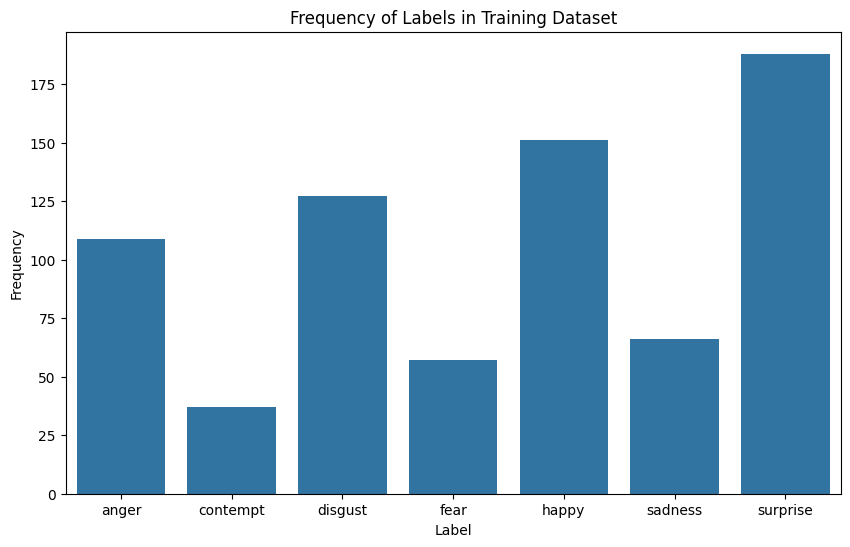

In [367]:
# Plotting Frequency of Labels in training dataset
Y_train_labels = np.argmax(Y_train, axis=1)
Y_train_labels_mapped = [original_label_mapping[label] for label in Y_train_labels]
train_df = pd.DataFrame({'label': Y_train_labels_mapped})

plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=train_df, order=list(original_label_mapping.values()))
plt.title('Frequency of Labels in Training Dataset')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

In [369]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Function to load images from each subfolder
def load_images_from_folder(folder, num_images=3):
    images = []
    for filename in os.listdir(folder)[:num_images]:  # Load only the first `num_images` images
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path) and img_path.endswith('.png'):
            img = mpimg.imread(img_path)
            images.append(img)
    return images

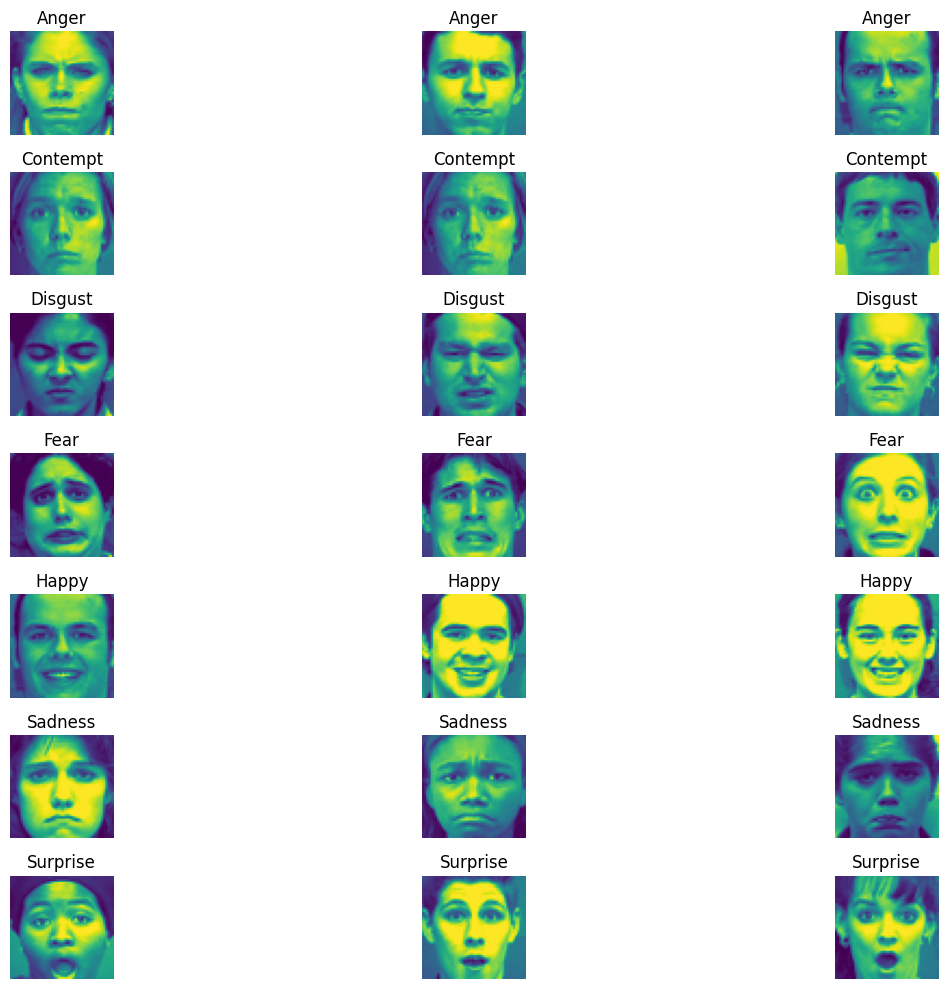

In [370]:
# Load a few images from each emotion subfolder
emotion_images = {emotion: load_images_from_folder(os.path.join(dataset_folder, emotion)) for emotion in sub_folders}

# Display the images in a grid
num_images_per_row = 3
plt.figure(figsize=(15, 10))

for i, (emotion, images) in enumerate(emotion_images.items()):
    for j, img in enumerate(images):
        plt.subplot(len(sub_folders), num_images_per_row, i * num_images_per_row + j + 1)
        plt.imshow(img)
        plt.title(f"{emotion.capitalize()}")
        plt.axis('off')

plt.tight_layout()
plt.show()

Build CNN Architecture

In [371]:
input = Input(shape=(48, 48, 1))
conv1 = Conv2D(32, (3, 3), padding='same', strides=(1, 1), kernel_regularizer=l2(0.001))(input)
conv1 = Dropout(0.1)(conv1)
conv1 = Activation('relu')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), padding='same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool1)
conv2 = Dropout(0.1)(conv2)
conv2 = Activation('relu')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, (3, 3), padding='same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool2)
conv3 = Dropout(0.1)(conv3)
conv3 = Activation('relu')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(256, (3, 3), padding='same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool3)
conv4 = Dropout(0.1)(conv4)
conv4 = Activation('relu')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
flatten = Flatten()(pool4)
dense_1 = Dense(128, activation='relu')(flatten)
drop_1 = Dropout(0.2)(dense_1)
output = Dense(7, activation="softmax")(drop_1)  # Updated to 7 classes

# Model compile
model = Model(inputs=input, outputs=output)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])
model.summary()

# Configure Model Checkpoint
fle_s = '/content/drive/MyDrive/CP468 Project/dataset/output/emotion_model.h5'
checkpointer = ModelCheckpoint(fle_s, monitor='loss', verbose=1, save_best_only=True,
                               save_weights_only=False, mode='auto', save_freq='epoch')
callback_list = [checkpointer]

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_398 (Conv2D)         (None, 48, 48, 32)        320       
                                                                 
 dropout_44 (Dropout)        (None, 48, 48, 32)        0         
                                                                 
 activation_396 (Activation  (None, 48, 48, 32)        0         
 )                                                               
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 24, 24, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_399 (Conv2D)         (None, 24, 24, 64)        184

Model Training

In [372]:
save = model.fit(X_train, Y_train, batch_size=32, validation_data=(X_test, Y_test), epochs=50, callbacks=[callback_list])

Epoch 1/50
19/23 [=======================>......] - ETA: 0s - loss: 2.1100 - accuracy: 0.2072
Epoch 1: loss improved from inf to 2.08675, saving model to /content/drive/MyDrive/CP468 Project/dataset/output/emotion_model.h5
23/23 [==============================] - 2s 23ms/step - loss: 2.0867 - accuracy: 0.2231 - val_loss: 1.9852 - val_accuracy: 0.2480
Epoch 2/50
20/23 [=========================>....] - ETA: 0s - loss: 1.9245 - accuracy: 0.2719
Epoch 2: loss improved from 2.08675 to 1.91437, saving model to /content/drive/MyDrive/CP468 Project/dataset/output/emotion_model.h5
23/23 [==============================] - 0s 14ms/step - loss: 1.9144 - accuracy: 0.2721 - val_loss: 1.8343 - val_accuracy: 0.3211
Epoch 3/50
17/23 [=====================>........] - ETA: 0s - loss: 1.7269 - accuracy: 0.4338
Epoch 3: loss improved from 1.91437 to 1.65098, saving model to /content/drive/MyDrive/CP468 Project/dataset/output/emotion_model.h5
23/23 [==============================] - 0s 12ms/step - loss: 1

In [373]:
model.save('/content/drive/MyDrive/CP468 Project/dataset/output/emotion_model_output.h5')

Analyze and Plot Results

Text(0.5, 0.92, 'Lineplots showing loss and accuracy of CNN model by epochs')

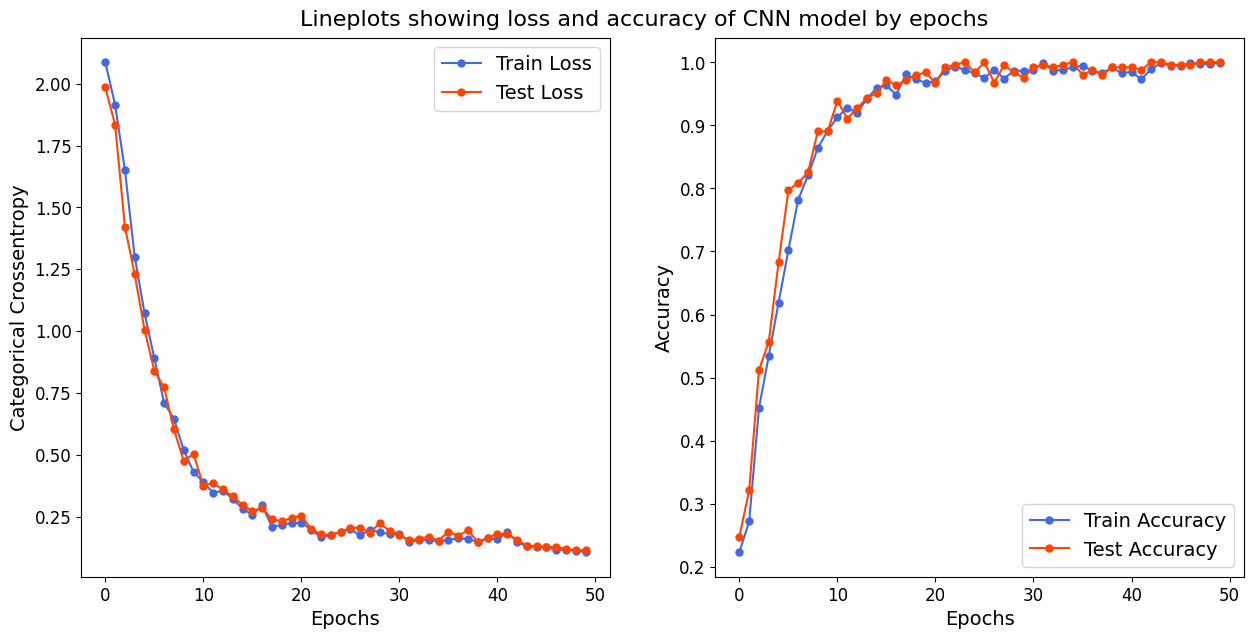

In [374]:
# Accuracy and Loss Graph
train_loss = save.history['loss']
test_loss = save.history['val_loss']
train_accuracy = save.history['accuracy']
test_accuracy = save.history['val_accuracy']

fig, ax = plt.subplots(ncols=2, figsize=(15, 7))
ax = ax.ravel()
ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color='orangered', marker='o', markersize=5)
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)
ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)
fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs", fontsize=16)

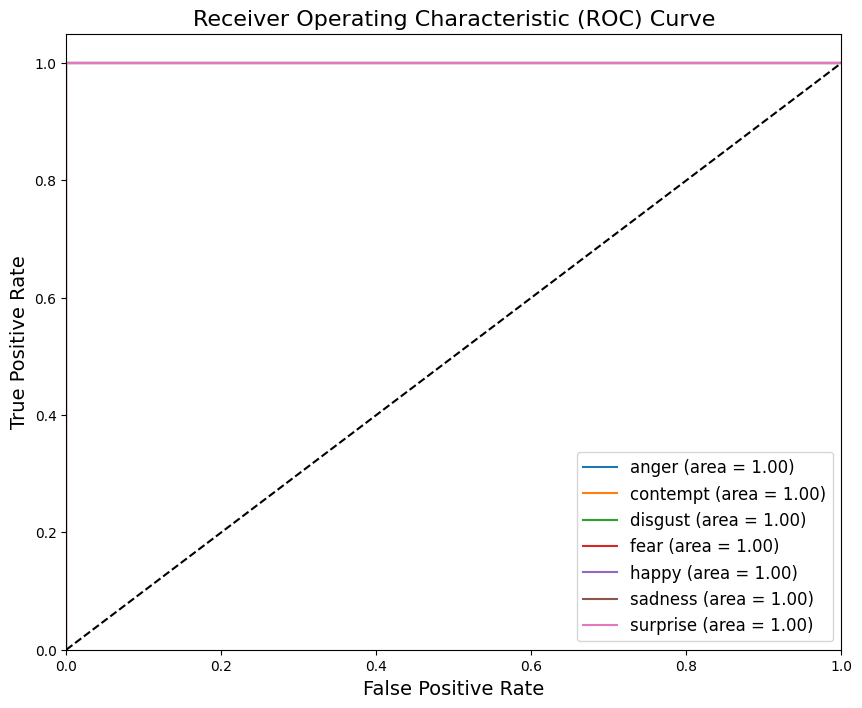

In [378]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Compute ROC and AUC
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_of_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(num_of_classes):
    plt.plot(fpr[i], tpr[i], label=f'{original_label_mapping[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.show()


8/8 [==============================] - 0s 2ms/step


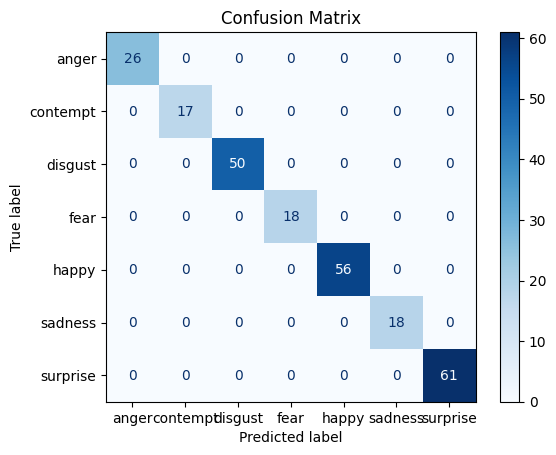

In [375]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Ensure correct shape for X_test
X_test_reshaped = X_test.reshape(-1, 48, 48, 1)

# Predict the test data
y_pred = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(original_label_mapping.values()))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [376]:
from sklearn.metrics import classification_report

# Ensure correct shape for X_test
X_test_reshaped = X_test.reshape(-1, 48, 48, 1)

# Evaluate on test data
test_loss, test_acc = model.evaluate(X_test_reshaped, Y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_acc}')

# Predict on test data
y_pred = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_test, axis=1)

# Print classification report
print(classification_report(y_true, y_pred_classes, target_names=list(original_label_mapping.values())))


8/8 [==============================] - 0s 3ms/step - loss: 0.1140 - accuracy: 1.0000
Test Loss: 0.11397843062877655, Test Accuracy: 1.0
8/8 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

       anger       1.00      1.00      1.00        26
    contempt       1.00      1.00      1.00        17
     disgust       1.00      1.00      1.00        50
        fear       1.00      1.00      1.00        18
       happy       1.00      1.00      1.00        56
     sadness       1.00      1.00      1.00        18
    surprise       1.00      1.00      1.00        61

    accuracy                           1.00       246
   macro avg       1.00      1.00      1.00       246
weighted avg       1.00      1.00      1.00       246



In [379]:
def compute_classification_metrics(cm):
    FP = cm.sum(axis=0) - np.diag(cm)
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)

    # Print classification metrics
    print(f'True Positives (TP): {TP}')
    print(f'True Negatives (TN): {TN}')
    print(f'False Positives (FP): {FP}')
    print(f'False Negatives (FN): {FN}')

# Compute and print metrics
compute_classification_metrics(cm)


True Positives (TP): [26 17 50 18 56 18 61]
True Negatives (TN): [220 229 196 228 190 228 185]
False Positives (FP): [0 0 0 0 0 0 0]
False Negatives (FN): [0 0 0 0 0 0 0]


Testing

1/1 [==============================] - 0s 18ms/step
Original Output: anger
Predicted Output: anger


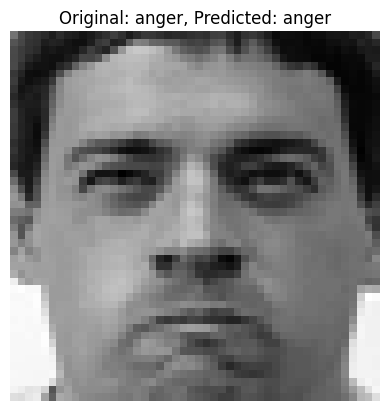

In [380]:
# Test with Random Image
image_index = random.randint(0, len(X_test) - 1)
original_label = original_label_mapping[np.argmax(Y_test[image_index])]
pred = model.predict(X_test[image_index].reshape(1, 48, 48, 1))
prediction_label = original_label_mapping[pred.argmax()]
print(f"Original Output: {original_label}")
print(f"Predicted Output: {prediction_label}")

# Display the image
plt.imshow(X_test[image_index].reshape(48, 48), cmap='gray')
plt.title(f"Original: {original_label}, Predicted: {prediction_label}")
plt.axis('off')
plt.show()

Saving istockphoto-1146642361-612x612.jpg to istockphoto-1146642361-612x612 (4).jpg
1/1 [==============================] - 0s 17ms/step


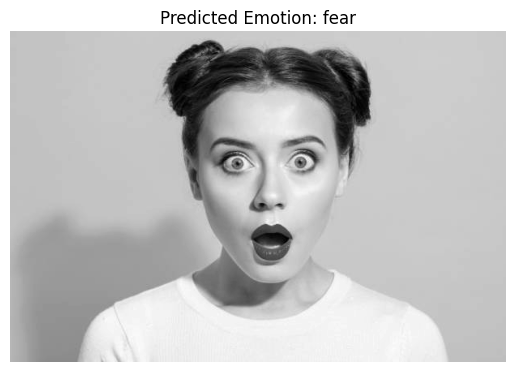

In [381]:
# Upload Random Image
from google.colab import files

# Function to preprocess the uploaded image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (48, 48))
    image = image / 255.0
    return image.reshape(1, 48, 48, 1)

# Function to upload an image and predict the emotion
def upload_and_predict_emotion(model):
    # Upload an image
    uploaded = files.upload()

    for image_name in uploaded.keys():
        # Preprocess the image
        preprocessed_image = preprocess_image(image_name)

        # Predict the emotion
        prediction = model.predict(preprocessed_image)
        predicted_label = original_label_mapping[np.argmax(prediction)]

        # Display the image and the prediction
        image = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE)
        plt.imshow(image, cmap='gray')
        plt.title(f"Predicted Emotion: {predicted_label}")
        plt.axis('off')
        plt.show()

# Use the function to upload an image and get the prediction
upload_and_predict_emotion(model)


Saving angry face.jpg to angry face (9).jpg
1/1 [==============================] - 0s 17ms/step


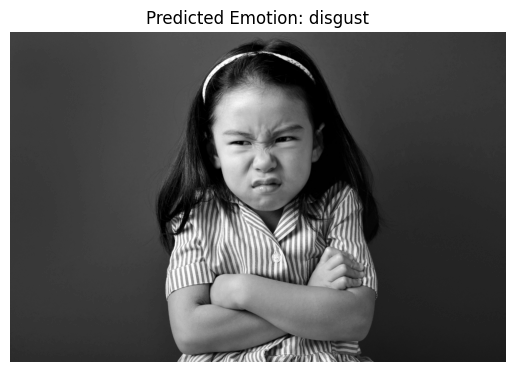

In [385]:
# Test 2
upload_and_predict_emotion(model)

Saving disgust.webp to disgust (4).webp
1/1 [==============================] - 0s 17ms/step


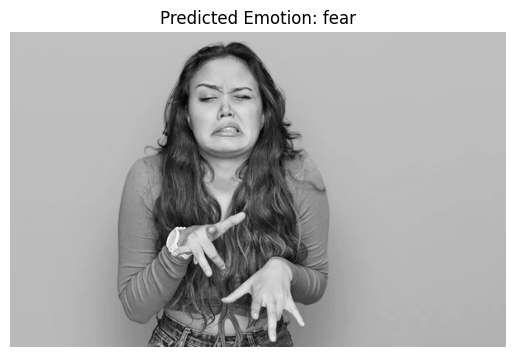

In [391]:
# Test 3
upload_and_predict_emotion(model)

# Phase 2 : Experimenting with Pre-trained Models Using Transfer Learning


Preprocess data to convert images to 3-channel

In [392]:
# Load and preprocess images
new_size = (75, 75)
images = []
labels = []

for sub_folder in sub_folders:
    sub_folder_index = temp.index(sub_folder)
    label = sub_folder_index
    path = os.path.join(dataset_folder, sub_folder)
    sub_folder_images = os.listdir(path)

    for image in sub_folder_images:
        image_path = os.path.join(path, image)
        image = cv2.imread(image_path)
        image = cv2.resize(image, new_size)
        images.append(image)
        labels.append(label)

In [393]:
# Convert lists to numpy arrays and normalize
images_x = np.array(images) / 255.0
labels_y = np.array(labels)

In [394]:
# Encode Labels
num_of_classes = 7
labels_y_encoded = tf.keras.utils.to_categorical(labels_y, num_classes=num_of_classes)

In [395]:
# Split Dataset in 75% for Training and 25% for Testing
X_train, X_test, Y_train, Y_test = train_test_split(images_x, labels_y_encoded, test_size=0.25, random_state=10)

In [396]:
# Check shapes
print(f'X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}')
print(f'X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}')

X_train shape: (735, 75, 75, 3), Y_train shape: (735, 7)
X_test shape: (246, 75, 75, 3), Y_test shape: (246, 7)


**(Model 1) Training the VGG16 model**

In [397]:
# Load VGG16 model without top layer
vgg16_base = VGG16(include_top=False, input_shape=(75, 75, 3))
for layer in vgg16_base.layers:
    layer.trainable = False

# Add custom top layers
vgg16_model = Sequential()
vgg16_model.add(vgg16_base)
vgg16_model.add(GlobalAveragePooling2D())
vgg16_model.add(Dense(128, activation='relu'))
vgg16_model.add(Dropout(0.5))

# 7 classes for emotions
vgg16_model.add(Dense(7, activation='softmax'))

In [398]:
# Compile the model
vgg16_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
vgg16_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
 4 (GlobalAveragePooling2D)                                      
                                                                 
 dense_50 (Dense)            (None, 128)               65664     
                                                                 
 dropout_49 (Dropout)        (None, 128)               0         
                                                                 
 dense_51 (Dense)            (None, 7)                 903       
                                                                 
Total params: 14781255 (56.39 MB)
Trainable params: 66567 (260.03 KB)
Non-trainable params: 14714688 (56.13 MB)
________

In [399]:
# Checkpoint callback to save the best model
checkpoint = ModelCheckpoint(f'{output_path}vgg16_emotion_model.h5', monitor='val_loss', verbose=1, save_best_only=True)

In [400]:
# Train the model
vgg16_history = vgg16_model.fit(X_train, Y_train, batch_size=32, validation_data=(X_test, Y_test), epochs=50, callbacks=[checkpoint])

Epoch 1/50
23/23 [==============================] - ETA: 0s - loss: 1.9105 - accuracy: 0.2653
Epoch 1: val_loss improved from inf to 1.66347, saving model to /content/drive/MyDrive/CP468 Project/dataset/output/vgg16_emotion_model.h5
23/23 [==============================] - 2s 55ms/step - loss: 1.9105 - accuracy: 0.2653 - val_loss: 1.6635 - val_accuracy: 0.4106
Epoch 2/50
22/23 [===========================>..] - ETA: 0s - loss: 1.6674 - accuracy: 0.3935
Epoch 2: val_loss improved from 1.66347 to 1.55534, saving model to /content/drive/MyDrive/CP468 Project/dataset/output/vgg16_emotion_model.h5
23/23 [==============================] - 1s 39ms/step - loss: 1.6597 - accuracy: 0.3959 - val_loss: 1.5553 - val_accuracy: 0.5569
Epoch 3/50
22/23 [===========================>..] - ETA: 0s - loss: 1.5237 - accuracy: 0.4872
Epoch 3: val_loss improved from 1.55534 to 1.43138, saving model to /content/drive/MyDrive/CP468 Project/dataset/output/vgg16_emotion_model.h5
23/23 [==========================

In [406]:
# Evaluate the model
vgg16_score = vgg16_model.evaluate(X_test, Y_test, verbose=0)
print(f'VGG16 Test loss: {vgg16_score[0]} / Test accuracy: {vgg16_score[1]}')

VGG16 Test loss: 0.3366314768791199 / Test accuracy: 0.9186992049217224


In [431]:
# Save the model
vgg16_model.save(f'{output_path}/vgg16_emotion_model.h5')

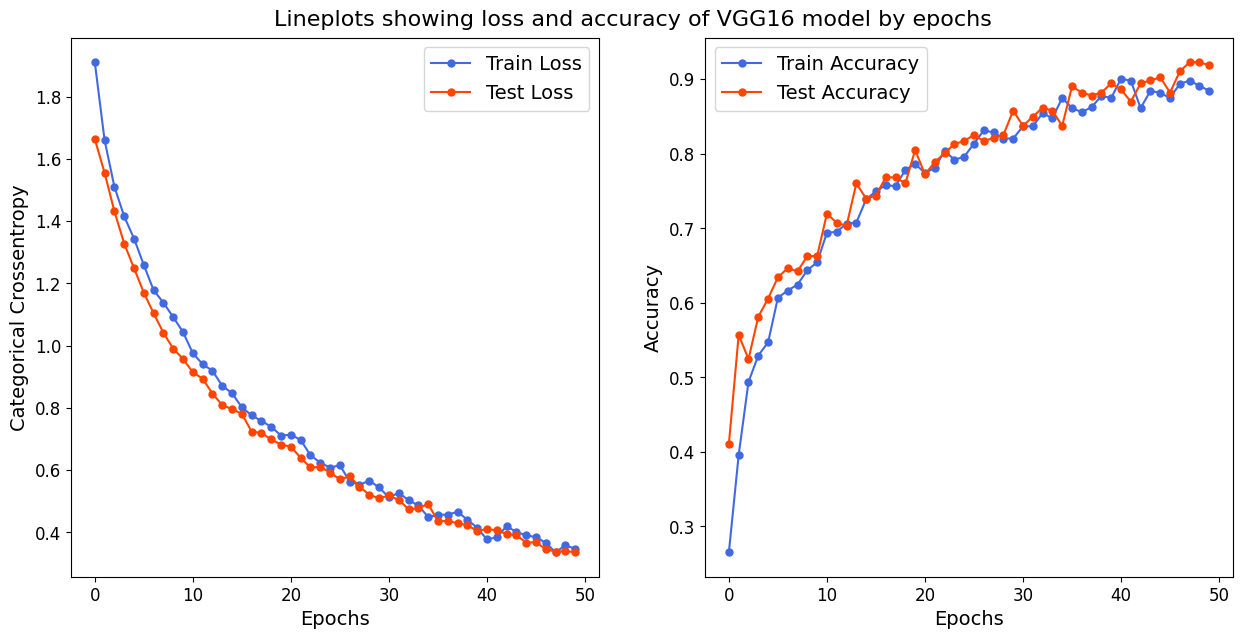

In [407]:
# Accuracy and Loss Graph
train_loss = vgg16_history.history['loss']
test_loss = vgg16_history.history['val_loss']
train_accuracy = vgg16_history.history['accuracy']
test_accuracy = vgg16_history.history['val_accuracy']

fig, ax = plt.subplots(ncols=2, figsize=(15, 7))
ax = ax.ravel()
ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color='orangered', marker='o', markersize=5)
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)
ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)
fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of VGG16 model by epochs", fontsize=16)
plt.show()


8/8 [==============================] - 0s 27ms/step


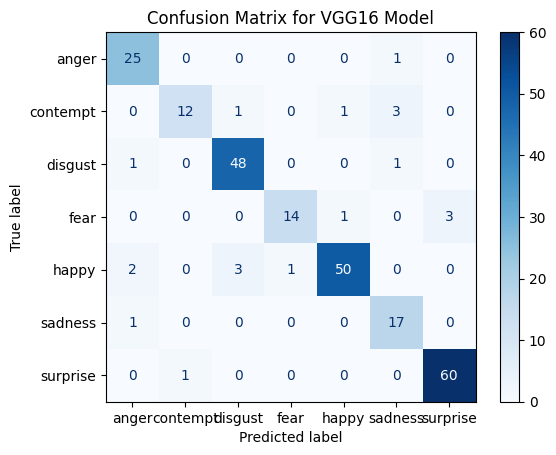

In [408]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict the test data
vgg16_y_pred = vgg16_model.predict(X_test)
vgg16_y_pred_classes = np.argmax(vgg16_y_pred, axis=1)
vgg16_y_true = np.argmax(Y_test, axis=1)

# Compute confusion matrix
vgg16_cm = confusion_matrix(vgg16_y_true, vgg16_y_pred_classes)

# Display confusion matrix
vgg16_disp = ConfusionMatrixDisplay(confusion_matrix=vgg16_cm, display_labels=list(original_label_mapping.values()))
vgg16_disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for VGG16 Model')
plt.show()


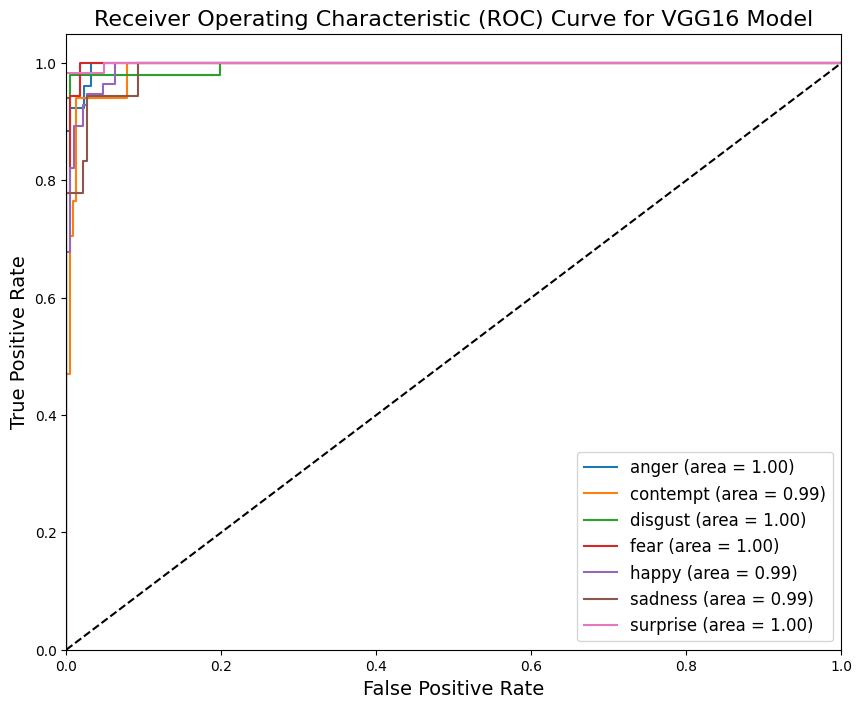

In [409]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Compute ROC and AUC
vgg16_fpr = {}
vgg16_tpr = {}
vgg16_roc_auc = {}

for i in range(num_of_classes):
    vgg16_fpr[i], vgg16_tpr[i], _ = roc_curve(Y_test[:, i], vgg16_y_pred[:, i])
    vgg16_roc_auc[i] = auc(vgg16_fpr[i], vgg16_tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(num_of_classes):
    plt.plot(vgg16_fpr[i], vgg16_tpr[i], label=f'{original_label_mapping[i]} (area = {vgg16_roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve for VGG16 Model', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.show()


In [412]:
def compute_classification_metrics(cm):
    FP = cm.sum(axis=0) - np.diag(cm)
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)

    # Print classification metrics
    print(f'True Positives (TP): {TP}')
    print(f'True Negatives (TN): {TN}')
    print(f'False Positives (FP): {FP}')
    print(f'False Negatives (FN): {FN}')

# Compute and print metrics
compute_classification_metrics(vgg16_cm)

True Positives (TP): [25 12 48 14 50 17 60]
True Negatives (TN): [216 228 192 227 188 223 182]
False Positives (FP): [4 1 4 1 2 5 3]
False Negatives (FN): [1 5 2 4 6 1 1]


In [414]:
# Print classification report
print(classification_report(vgg16_y_true, vgg16_y_pred_classes, target_names=list(original_label_mapping.values())))

              precision    recall  f1-score   support

       anger       0.86      0.96      0.91        26
    contempt       0.92      0.71      0.80        17
     disgust       0.92      0.96      0.94        50
        fear       0.93      0.78      0.85        18
       happy       0.96      0.89      0.93        56
     sadness       0.77      0.94      0.85        18
    surprise       0.95      0.98      0.97        61

    accuracy                           0.92       246
   macro avg       0.90      0.89      0.89       246
weighted avg       0.92      0.92      0.92       246



1/1 [==============================] - 0s 18ms/step
Original Output: surprise
Predicted Output: surprise


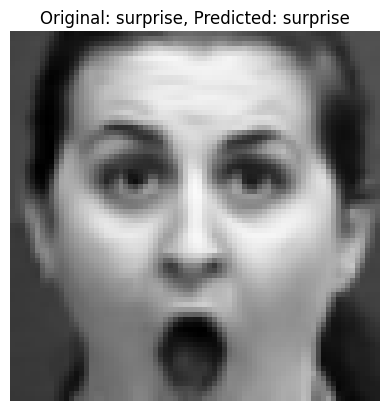

In [415]:
# Test with Random Image
image_index = random.randint(0, len(X_test) - 1)
original_label = original_label_mapping[np.argmax(Y_test[image_index])]
pred = vgg16_model.predict(X_test[image_index].reshape(1, 75, 75, 3))
prediction_label = original_label_mapping[pred.argmax()]
print(f"Original Output: {original_label}")
print(f"Predicted Output: {prediction_label}")

# Display the image
plt.imshow(X_test[image_index])
plt.title(f"Original: {original_label}, Predicted: {prediction_label}")
plt.axis('off')
plt.show()

**(Model 2) Training the ResNet50 Model**

In [416]:
# Define ResNet50 model
resnet50_base = ResNet50(include_top=False, input_shape=(75, 75, 3))
for layer in resnet50_base.layers:
    layer.trainable = False

In [417]:
# Add top layers
resnet50_model = Sequential()
resnet50_model.add(resnet50_base)
resnet50_model.add(GlobalAveragePooling2D())
resnet50_model.add(Dense(128, activation='relu'))
resnet50_model.add(Dropout(0.5))

# 7 classes for emotions
resnet50_model.add(Dense(7, activation='softmax'))

In [418]:
# Compile the model
resnet50_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
resnet50_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
 5 (GlobalAveragePooling2D)                                      
                                                                 
 dense_52 (Dense)            (None, 128)               262272    
                                                                 
 dropout_50 (Dropout)        (None, 128)               0         
                                                                 
 dense_53 (Dense)            (None, 7)                 903       
                                                                 
Total params: 23850887 (90.98 MB)
Trainable params: 263175 (1.00 MB)
Non-trainable params: 23587712 (89.98 MB)
_________

In [419]:
# Checkpoint callback to save the best model
checkpoint = ModelCheckpoint(f'{output_path}resnet50_emotion_model.h5', monitor='val_loss', verbose=1, save_best_only=True)

In [420]:
# Train the model
resnet50_history = resnet50_model.fit(X_train, Y_train, batch_size=32, validation_data=(X_test, Y_test), epochs=50, callbacks=[checkpoint])

Epoch 1/50
23/23 [==============================] - ETA: 0s - loss: 1.9417 - accuracy: 0.2082
Epoch 1: val_loss improved from inf to 1.79332, saving model to /content/drive/MyDrive/CP468 Project/dataset/output/resnet50_emotion_model.h5
23/23 [==============================] - 5s 103ms/step - loss: 1.9417 - accuracy: 0.2082 - val_loss: 1.7933 - val_accuracy: 0.3008
Epoch 2/50
22/23 [===========================>..] - ETA: 0s - loss: 1.8288 - accuracy: 0.2642
Epoch 2: val_loss improved from 1.79332 to 1.76794, saving model to /content/drive/MyDrive/CP468 Project/dataset/output/resnet50_emotion_model.h5
23/23 [==============================] - 1s 51ms/step - loss: 1.8289 - accuracy: 0.2639 - val_loss: 1.7679 - val_accuracy: 0.3008
Epoch 3/50
22/23 [===========================>..] - ETA: 0s - loss: 1.7950 - accuracy: 0.2912
Epoch 3: val_loss improved from 1.76794 to 1.76029, saving model to /content/drive/MyDrive/CP468 Project/dataset/output/resnet50_emotion_model.h5
23/23 [================

In [432]:
# Save the model
resnet50_model.save(f'{output_path}resnet50_emotion_model.h5')

In [421]:
# Evaluate the model
resnet50_score = resnet50_model.evaluate(X_test, Y_test, verbose=0)
print(f'ResNet50 Test loss: {resnet50_score[0]} / Test accuracy: {resnet50_score[1]}')

ResNet50 Test loss: 1.0468350648880005 / Test accuracy: 0.6341463327407837


Testing

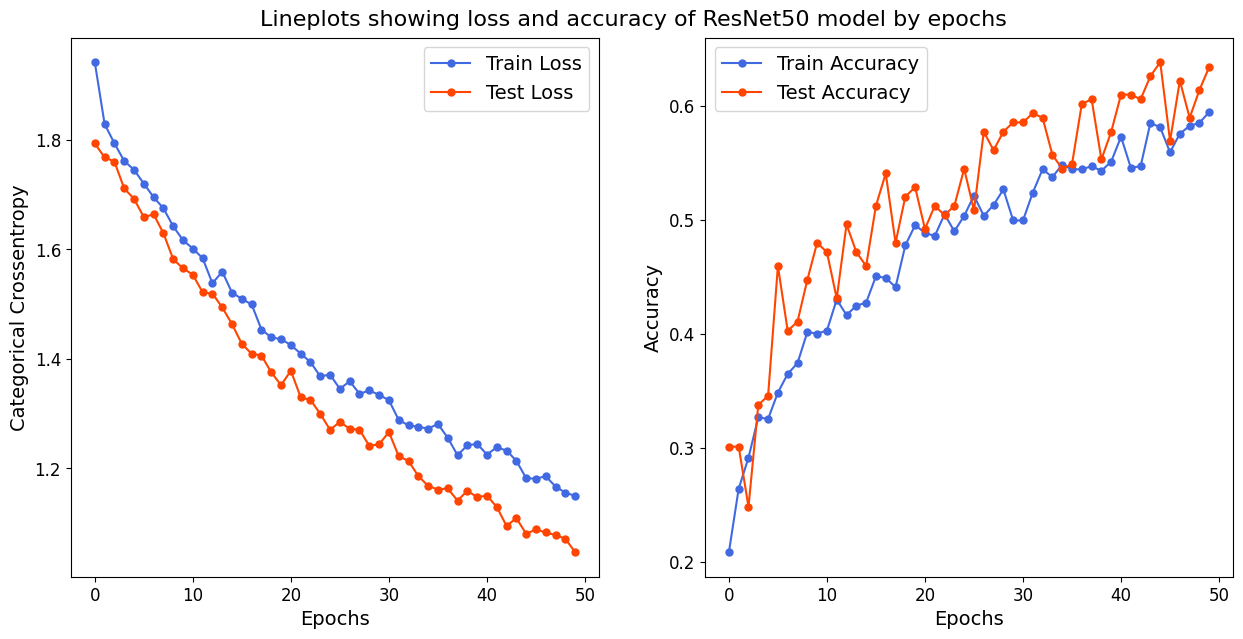

In [422]:
# Accuracy and Loss Graph
train_loss = resnet50_history.history['loss']
test_loss = resnet50_history.history['val_loss']
train_accuracy = resnet50_history.history['accuracy']
test_accuracy = resnet50_history.history['val_accuracy']

fig, ax = plt.subplots(ncols=2, figsize=(15, 7))
ax = ax.ravel()
ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color='orangered', marker='o', markersize=5)
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)
ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)
fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of ResNet50 model by epochs", fontsize=16)
plt.show()


8/8 [==============================] - 1s 18ms/step


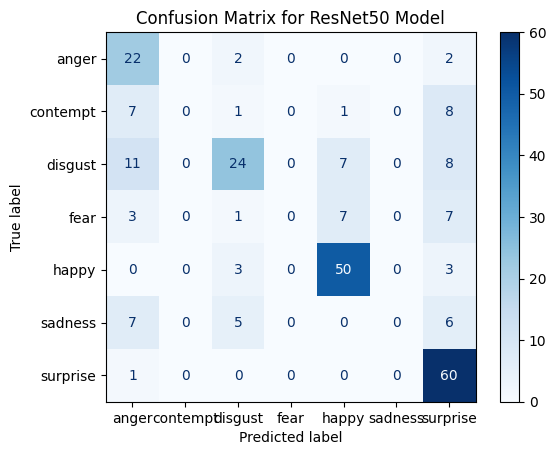

In [423]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict the test data
resnet50_y_pred = resnet50_model.predict(X_test)
resnet50_y_pred_classes = np.argmax(resnet50_y_pred, axis=1)
resnet50_y_true = np.argmax(Y_test, axis=1)

# Compute confusion matrix
resnet50_cm = confusion_matrix(resnet50_y_true, resnet50_y_pred_classes)

# Display confusion matrix
resnet50_disp = ConfusionMatrixDisplay(confusion_matrix=resnet50_cm, display_labels=list(original_label_mapping.values()))
resnet50_disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for ResNet50 Model')
plt.show()

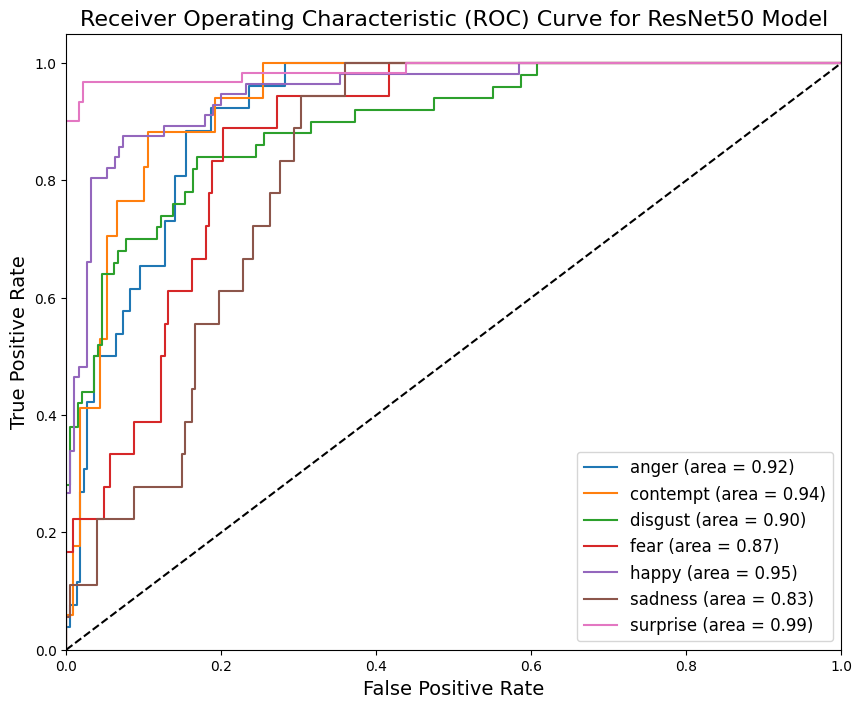

In [424]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Compute ROC and AUC
resnet50_fpr = {}
resnet50_tpr = {}
resnet50_roc_auc = {}

for i in range(num_of_classes):
    resnet50_fpr[i], resnet50_tpr[i], _ = roc_curve(Y_test[:, i], resnet50_y_pred[:, i])
    resnet50_roc_auc[i] = auc(resnet50_fpr[i], resnet50_tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(num_of_classes):
    plt.plot(resnet50_fpr[i], resnet50_tpr[i], label=f'{original_label_mapping[i]} (area = {resnet50_roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve for ResNet50 Model', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.show()

In [425]:
def compute_classification_metrics(cm):
    FP = cm.sum(axis=0) - np.diag(cm)
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)

    # Print classification metrics
    print(f'True Positives (TP): {TP}')
    print(f'True Negatives (TN): {TN}')
    print(f'False Positives (FP): {FP}')
    print(f'False Negatives (FN): {FN}')

# Compute and print metrics
compute_classification_metrics(resnet50_cm)


True Positives (TP): [22  0 24  0 50  0 60]
True Negatives (TN): [191 229 184 228 175 228 151]
False Positives (FP): [29  0 12  0 15  0 34]
False Negatives (FN): [ 4 17 26 18  6 18  1]


In [426]:
# Print classification report
print(classification_report(resnet50_y_true, resnet50_y_pred_classes, target_names=list(original_label_mapping.values())))

              precision    recall  f1-score   support

       anger       0.43      0.85      0.57        26
    contempt       0.00      0.00      0.00        17
     disgust       0.67      0.48      0.56        50
        fear       0.00      0.00      0.00        18
       happy       0.77      0.89      0.83        56
     sadness       0.00      0.00      0.00        18
    surprise       0.64      0.98      0.77        61

    accuracy                           0.63       246
   macro avg       0.36      0.46      0.39       246
weighted avg       0.51      0.63      0.55       246



1/1 [==============================] - 0s 25ms/step
Original Output: happy
Predicted Output: happy


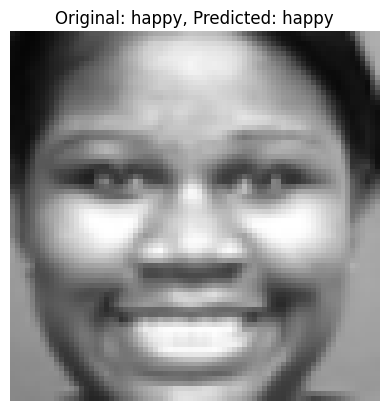

In [427]:
# Test with Random Image
image_index = random.randint(0, len(X_test) - 1)
original_label = original_label_mapping[np.argmax(Y_test[image_index])]
pred = resnet50_model.predict(X_test[image_index].reshape(1, 75, 75, 3))
prediction_label = original_label_mapping[pred.argmax()]
print(f"Original Output: {original_label}")
print(f"Predicted Output: {prediction_label}")

# Display the image
plt.imshow(X_test[image_index])
plt.title(f"Original: {original_label}, Predicted: {prediction_label}")
plt.axis('off')
plt.show()


**(Model 3) Training the InceptionV3 Model**

In [428]:
# Define InceptionV3 model
inceptionv3_base = InceptionV3(include_top=False, input_shape=(75, 75, 3))
for layer in inceptionv3_base.layers:
    layer.trainable = False

In [429]:
# Add Custom Layers
inceptionv3_model = Sequential()
inceptionv3_model.add(inceptionv3_base)
inceptionv3_model.add(GlobalAveragePooling2D())
inceptionv3_model.add(Dense(128, activation='relu'))
inceptionv3_model.add(Dropout(0.5))

# 7 classes for emotions
inceptionv3_model.add(Dense(7, activation='softmax'))

In [430]:
# Compile the model
inceptionv3_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
inceptionv3_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
 6 (GlobalAveragePooling2D)                                      
                                                                 
 dense_54 (Dense)            (None, 128)               262272    
                                                                 
 dropout_51 (Dropout)        (None, 128)               0         
                                                                 
 dense_55 (Dense)            (None, 7)                 903       
                                                                 
Total params: 22065959 (84.17 MB)
Trainable params: 263175 (1.00 MB)
Non-trainable params: 21802784 (83.17 MB)
_________

In [433]:
# Checkpoint callback to save the best model
checkpoint = ModelCheckpoint(f'{output_path}inceptionv3_emotion_model.h5', monitor='val_loss', verbose=1, save_best_only=True)

In [434]:
# Train the model
inceptionv3_history = inceptionv3_model.fit(X_train, Y_train, batch_size=32, validation_data=(X_test, Y_test), epochs=50, callbacks=[checkpoint])

Epoch 1/50
23/23 [==============================] - ETA: 0s - loss: 1.6130 - accuracy: 0.4286
Epoch 1: val_loss improved from inf to 1.09237, saving model to /content/drive/MyDrive/CP468 Project/dataset/output/inceptionv3_emotion_model.h5
23/23 [==============================] - 7s 117ms/step - loss: 1.6130 - accuracy: 0.4286 - val_loss: 1.0924 - val_accuracy: 0.6341
Epoch 2/50
23/23 [==============================] - ETA: 0s - loss: 1.1114 - accuracy: 0.6190
Epoch 2: val_loss improved from 1.09237 to 0.87865, saving model to /content/drive/MyDrive/CP468 Project/dataset/output/inceptionv3_emotion_model.h5
23/23 [==============================] - 1s 54ms/step - loss: 1.1114 - accuracy: 0.6190 - val_loss: 0.8787 - val_accuracy: 0.7276
Epoch 3/50
20/23 [=========================>....] - ETA: 0s - loss: 0.8847 - accuracy: 0.7141
Epoch 3: val_loss improved from 0.87865 to 0.70969, saving model to /content/drive/MyDrive/CP468 Project/dataset/output/inceptionv3_emotion_model.h5
23/23 [=======

In [435]:
# Save the model
inceptionv3_model.save(f'{output_path}inceptionv3_emotion_model.h5')

In [436]:
# Evaluate the model
inceptionv3_score = inceptionv3_model.evaluate(X_test, Y_test, verbose=0)
print(f'InceptionV3 Test loss: {inceptionv3_score[0]} / Test accuracy: {inceptionv3_score[1]}')

InceptionV3 Test loss: 0.010854579508304596 / Test accuracy: 1.0


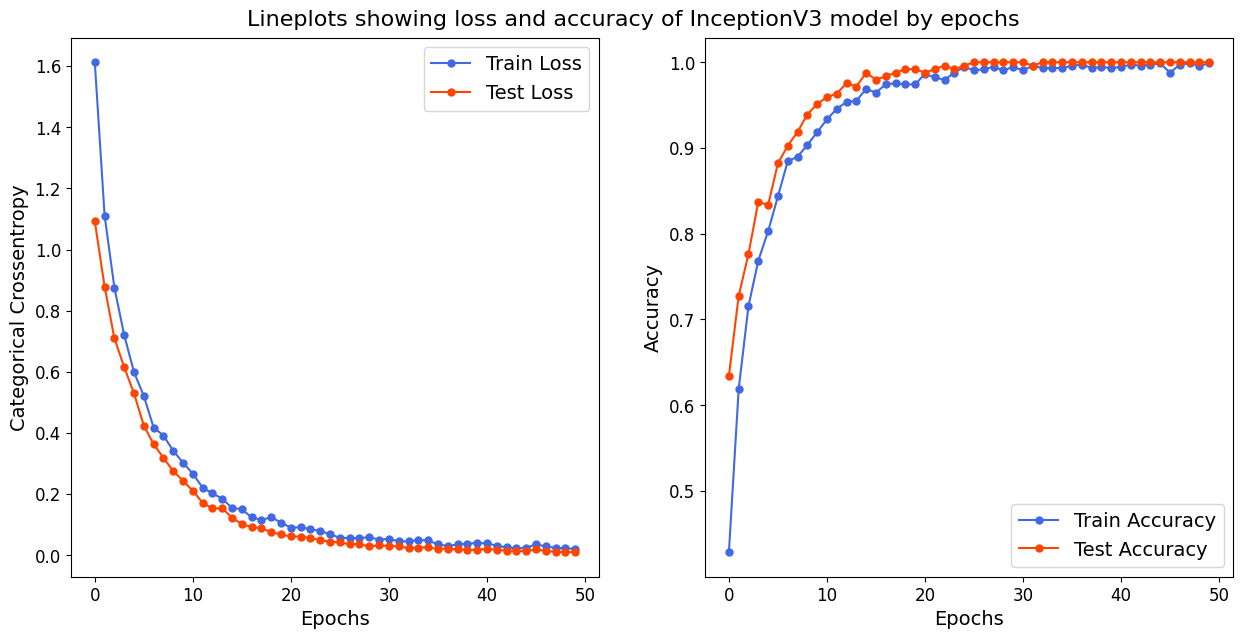

In [437]:
# Accuracy and Loss Graph
train_loss = inceptionv3_history.history['loss']
test_loss = inceptionv3_history.history['val_loss']
train_accuracy = inceptionv3_history.history['accuracy']
test_accuracy = inceptionv3_history.history['val_accuracy']

fig, ax = plt.subplots(ncols=2, figsize=(15, 7))
ax = ax.ravel()
ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color='orangered', marker='o', markersize=5)
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)
ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)
fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of InceptionV3 model by epochs", fontsize=16)
plt.show()


8/8 [==============================] - 1s 22ms/step


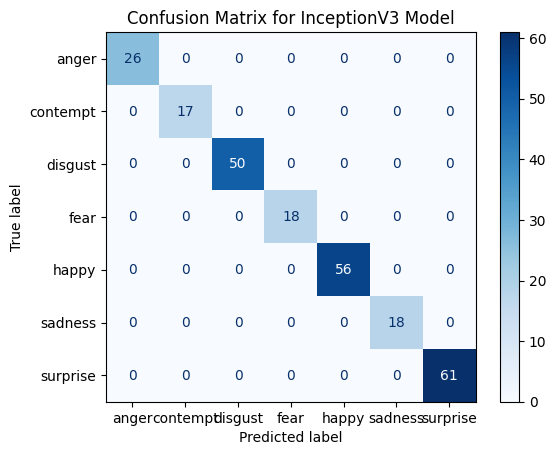

In [438]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict the test data
inceptionv3_y_pred = inceptionv3_model.predict(X_test)
inceptionv3_y_pred_classes = np.argmax(inceptionv3_y_pred, axis=1)
inceptionv3_y_true = np.argmax(Y_test, axis=1)

# Compute confusion matrix
inceptionv3_cm = confusion_matrix(inceptionv3_y_true, inceptionv3_y_pred_classes)

# Display confusion matrix
inceptionv3_disp = ConfusionMatrixDisplay(confusion_matrix=inceptionv3_cm, display_labels=list(original_label_mapping.values()))
inceptionv3_disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for InceptionV3 Model')
plt.show()

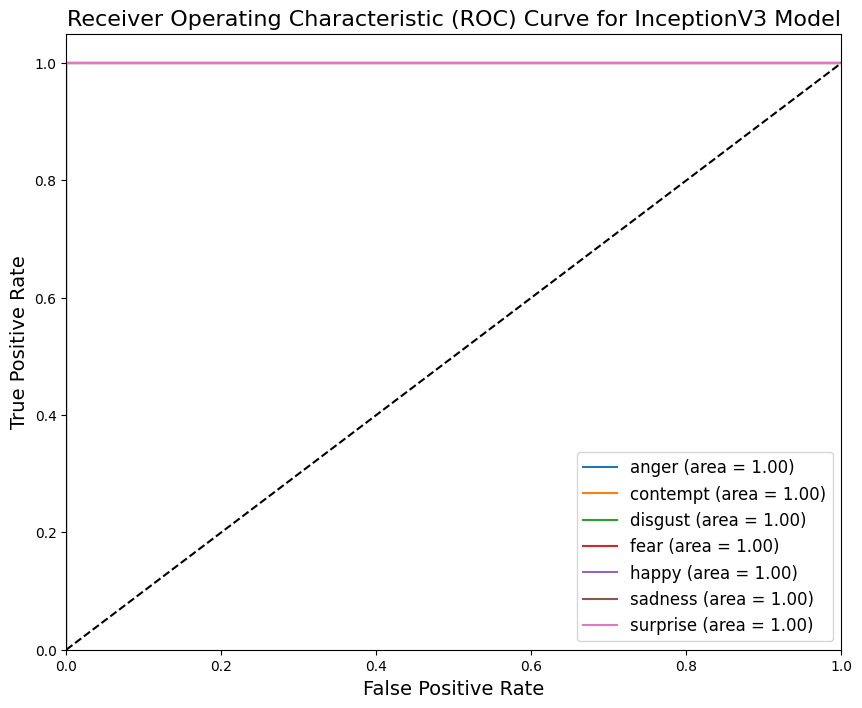

In [439]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Compute ROC and AUC
inceptionv3_fpr = {}
inceptionv3_tpr = {}
inceptionv3_roc_auc = {}

for i in range(num_of_classes):
    inceptionv3_fpr[i], inceptionv3_tpr[i], _ = roc_curve(Y_test[:, i], inceptionv3_y_pred[:, i])
    inceptionv3_roc_auc[i] = auc(inceptionv3_fpr[i], inceptionv3_tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(num_of_classes):
    plt.plot(inceptionv3_fpr[i], inceptionv3_tpr[i], label=f'{original_label_mapping[i]} (area = {inceptionv3_roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve for InceptionV3 Model', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.show()

In [440]:
def compute_classification_metrics(cm):
    FP = cm.sum(axis=0) - np.diag(cm)
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)

    # Print classification metrics
    print(f'True Positives (TP): {TP}')
    print(f'True Negatives (TN): {TN}')
    print(f'False Positives (FP): {FP}')
    print(f'False Negatives (FN): {FN}')

# Compute and print metrics
compute_classification_metrics(inceptionv3_cm)

True Positives (TP): [26 17 50 18 56 18 61]
True Negatives (TN): [220 229 196 228 190 228 185]
False Positives (FP): [0 0 0 0 0 0 0]
False Negatives (FN): [0 0 0 0 0 0 0]


In [441]:
# Print classification report
print(classification_report(inceptionv3_y_true, inceptionv3_y_pred_classes, target_names=list(original_label_mapping.values())))

              precision    recall  f1-score   support

       anger       1.00      1.00      1.00        26
    contempt       1.00      1.00      1.00        17
     disgust       1.00      1.00      1.00        50
        fear       1.00      1.00      1.00        18
       happy       1.00      1.00      1.00        56
     sadness       1.00      1.00      1.00        18
    surprise       1.00      1.00      1.00        61

    accuracy                           1.00       246
   macro avg       1.00      1.00      1.00       246
weighted avg       1.00      1.00      1.00       246



Testing

1/1 [==============================] - 0s 27ms/step
Original Output: disgust
Predicted Output: disgust


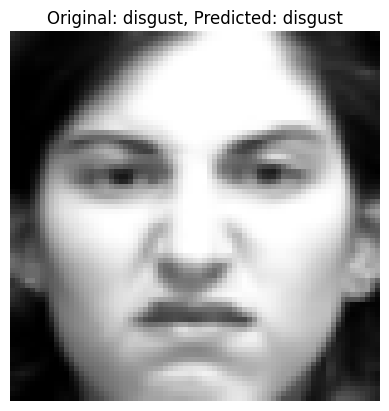

In [443]:
# Test with Random Image
image_index = random.randint(0, len(X_test) - 1)
original_label = original_label_mapping[np.argmax(Y_test[image_index])]
pred = inceptionv3_model.predict(X_test[image_index].reshape(1, 75, 75, 3))
prediction_label = original_label_mapping[pred.argmax()]
print(f"Original Output: {original_label}")
print(f"Predicted Output: {prediction_label}")

# Display the image
plt.imshow(X_test[image_index])
plt.title(f"Original: {original_label}, Predicted: {prediction_label}")
plt.axis('off')
plt.show()


Ensemble Prediction

In [444]:
# Load the pre-trained models
vgg16_model = tf.keras.models.load_model(f'{output_path}vgg16_emotion_model.h5')
resnet50_model = tf.keras.models.load_model(f'{output_path}resnet50_emotion_model.h5')
inceptionv3_model = tf.keras.models.load_model(f'{output_path}inceptionv3_emotion_model.h5')


In [445]:
# Majority Voting Function
def majority_voting(models, X):
    predictions = [model.predict(X) for model in models]
    predictions = np.array(predictions)
    majority_votes = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=np.argmax(predictions, axis=2))
    return majority_votes

In [446]:
# List of models
models = [vgg16_model, resnet50_model, inceptionv3_model]

# Get predictions using majority voting
ensemble_predictions = majority_voting(models, X_test)

8/8 [==============================] - 3s 22ms/step


In [447]:
# Convert one-hot encoded Y_test back to labels
Y_test_labels = np.argmax(Y_test, axis=1)

# Calculate accuracy
ensemble_accuracy = np.mean(ensemble_predictions == Y_test_labels)
print(f'Ensemble Model Test Accuracy: {ensemble_accuracy}')

Ensemble Model Test Accuracy: 0.9552845528455285


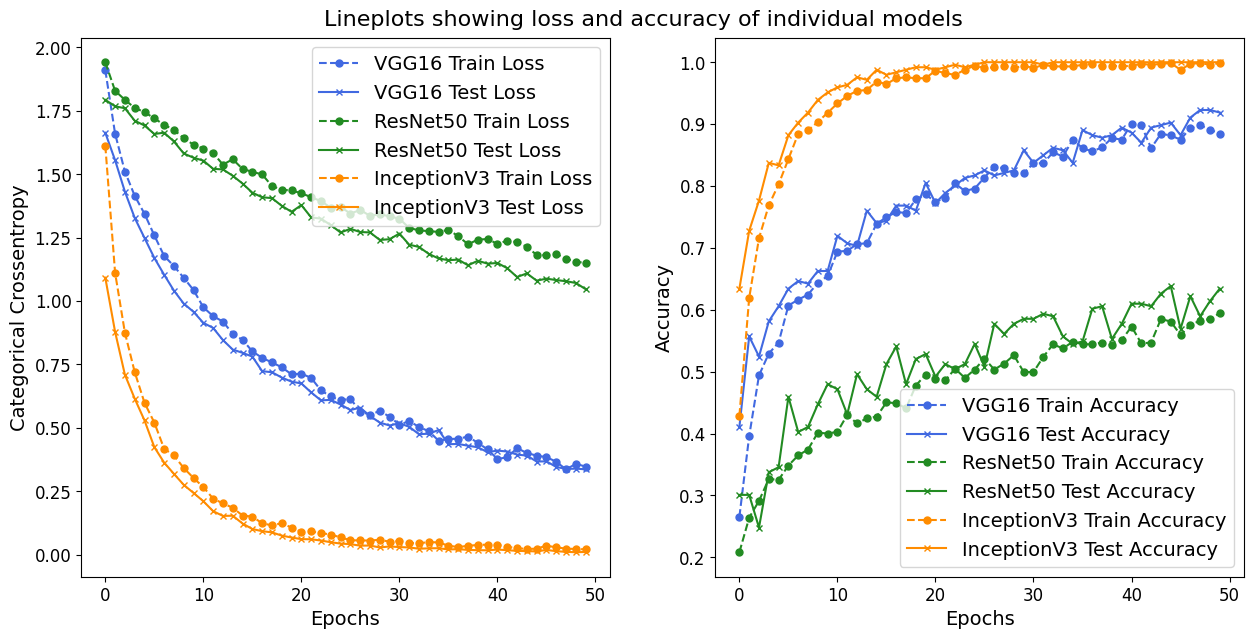

In [448]:
def plot_ensemble_results():
    fig, ax = plt.subplots(ncols=2, figsize=(15, 7))
    ax = ax.ravel()

    # Plot individual model results
    models_history = [vgg16_history, resnet50_history, inceptionv3_history]
    labels = ['VGG16', 'ResNet50', 'InceptionV3']
    colors = ['royalblue', 'forestgreen', 'darkorange']

    for i, history in enumerate(models_history):
        train_loss = history.history['loss']
        test_loss = history.history['val_loss']
        train_accuracy = history.history['accuracy']
        test_accuracy = history.history['val_accuracy']

        ax[0].plot(train_loss, label=f'{labels[i]} Train Loss', color=colors[i], marker='o', markersize=5, linestyle='dashed')
        ax[0].plot(test_loss, label=f'{labels[i]} Test Loss', color=colors[i], marker='x', markersize=5)
        ax[1].plot(train_accuracy, label=f'{labels[i]} Train Accuracy', color=colors[i], marker='o', markersize=5, linestyle='dashed')
        ax[1].plot(test_accuracy, label=f'{labels[i]} Test Accuracy', color=colors[i], marker='x', markersize=5)

    ax[0].set_xlabel('Epochs', fontsize=14)
    ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)
    ax[0].legend(fontsize=14)
    ax[0].tick_params(axis='both', labelsize=12)
    ax[1].set_xlabel('Epochs', fontsize=14)
    ax[1].set_ylabel('Accuracy', fontsize=14)
    ax[1].legend(fontsize=14)
    ax[1].tick_params(axis='both', labelsize=12)
    fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of individual models", fontsize=16)
    plt.show()

plot_ensemble_results()

8/8 [==============================] - 0s 12ms/step


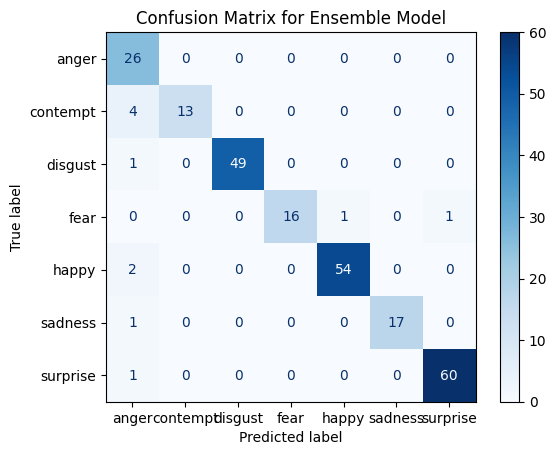

In [449]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions using majority voting
ensemble_predictions = majority_voting(models, X_test)

# Convert one-hot encoded Y_test back to labels
Y_test_labels = np.argmax(Y_test, axis=1)

# Compute confusion matrix
ensemble_cm = confusion_matrix(Y_test_labels, ensemble_predictions)

# Display confusion matrix
ensemble_disp = ConfusionMatrixDisplay(confusion_matrix=ensemble_cm, display_labels=list(original_label_mapping.values()))
ensemble_disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Ensemble Model')
plt.show()

8/8 [==============================] - 0s 13ms/step


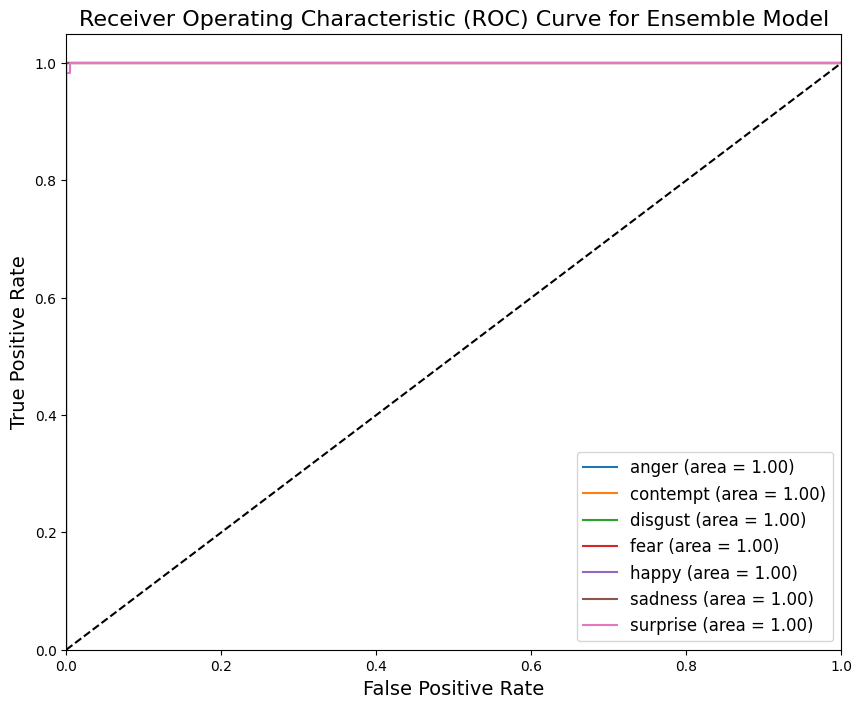

In [450]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Compute ROC and AUC for ensemble model
ensemble_fpr = {}
ensemble_tpr = {}
ensemble_roc_auc = {}

# Predict probabilities for ensemble model
ensemble_pred_prob = np.sum([model.predict(X_test) for model in models], axis=0)

for i in range(num_of_classes):
    ensemble_fpr[i], ensemble_tpr[i], _ = roc_curve(Y_test[:, i], ensemble_pred_prob[:, i])
    ensemble_roc_auc[i] = auc(ensemble_fpr[i], ensemble_tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(num_of_classes):
    plt.plot(ensemble_fpr[i], ensemble_tpr[i], label=f'{original_label_mapping[i]} (area = {ensemble_roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve for Ensemble Model', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.show()

In [451]:
def compute_classification_metrics(cm):
    FP = cm.sum(axis=0) - np.diag(cm)
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)

    # Print classification metrics
    print(f'True Positives (TP): {TP}')
    print(f'True Negatives (TN): {TN}')
    print(f'False Positives (FP): {FP}')
    print(f'False Negatives (FN): {FN}')

# Compute and print metrics
compute_classification_metrics(ensemble_cm)

True Positives (TP): [26 13 49 16 54 17 60]
True Negatives (TN): [211 229 196 228 189 228 184]
False Positives (FP): [9 0 0 0 1 0 1]
False Negatives (FN): [0 4 1 2 2 1 1]


In [452]:
# Print classification report
print(classification_report(Y_test_labels, ensemble_predictions, target_names=list(original_label_mapping.values())))

              precision    recall  f1-score   support

       anger       0.74      1.00      0.85        26
    contempt       1.00      0.76      0.87        17
     disgust       1.00      0.98      0.99        50
        fear       1.00      0.89      0.94        18
       happy       0.98      0.96      0.97        56
     sadness       1.00      0.94      0.97        18
    surprise       0.98      0.98      0.98        61

    accuracy                           0.96       246
   macro avg       0.96      0.93      0.94       246
weighted avg       0.96      0.96      0.96       246



Testing

In [454]:
# Function to get predictions from each model and the ensemble model
def get_model_predictions(models, image):
    predictions = [model.predict(image) for model in models]
    predicted_labels = [original_label_mapping[np.argmax(pred)] for pred in predictions]
    return predictions, predicted_labels

# Function to get ensemble prediction using majority voting
def get_ensemble_prediction(models, image):
    ensemble_pred = majority_voting(models, image)
    ensemble_label = original_label_mapping[ensemble_pred[0]]
    return ensemble_label

# Test with Random Image using Ensemble Model
def test_with_random_image(models):
  image_index = random.randint(0, len(X_test) - 1)
  original_label = original_label_mapping[np.argmax(Y_test[image_index])]
  image = X_test[image_index].reshape(1, 75, 75, 3)

  # Get predictions from each model
  model_predictions, model_labels = get_model_predictions(models, image)

  # Print the predictions from each model
  for i, model_name in enumerate(['VGG16', 'ResNet50', 'InceptionV3']):
      print(f"{model_name} Prediction: {model_labels[i]}")

  # Get and print ensemble prediction
  ensemble_label = get_ensemble_prediction(models, image)
  print(f"Original Output: {original_label}")
  print(f"Ensemble Prediction: {ensemble_label}")

  # Display the image with the ensemble prediction
  plt.imshow(X_test[image_index])
  plt.title(f"Original: {original_label}, Ensemble Predicted: {ensemble_label}")
  plt.axis('off')
  plt.show()


1/1 [==============================] - 0s 23ms/step
VGG16 Prediction: contempt
ResNet50 Prediction: anger
InceptionV3 Prediction: contempt
1/1 [==============================] - 0s 25ms/step
Original Output: contempt
Ensemble Prediction: contempt


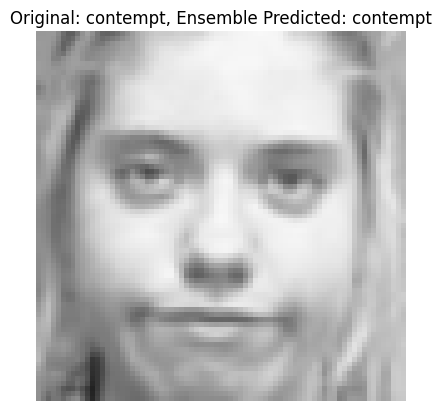

In [455]:
# Test 1
test_with_random_image(models)

1/1 [==============================] - 0s 23ms/step
VGG16 Prediction: happy
ResNet50 Prediction: happy
InceptionV3 Prediction: happy
1/1 [==============================] - 0s 23ms/step
Original Output: happy
Ensemble Prediction: happy


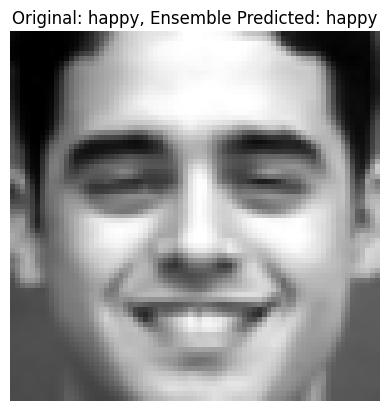

In [456]:
# Test 2
test_with_random_image(models)

In [350]:
# Function to preprocess the uploaded image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (75, 75))
    image = image / 255.0
    return image.reshape(1, 75, 75, 3)


# Function to get predictions from each model and the ensemble model
def get_model_predictions(models, image):
    predictions = [model.predict(image) for model in models]
    predicted_labels = [original_label_mapping[np.argmax(pred)] for pred in predictions]
    return predictions, predicted_labels

# Function to get ensemble prediction using majority voting
def get_ensemble_prediction(models, image):
    ensemble_pred = majority_voting(models, image)
    ensemble_label = original_label_mapping[ensemble_pred[0]]
    return ensemble_label

# Function to upload an image and predict the emotion using the ensemble model
def upload_and_predict_emotion_ensemble(models):
    # Upload an image
    uploaded = files.upload()

    for image_name in uploaded.keys():
        # Preprocess the image
        preprocessed_image = preprocess_image(image_name)

        # Predict the emotion using each individual model
        model_predictions, model_labels = get_model_predictions(models, preprocessed_image)

        # Print the predictions from each model
        for i, model_name in enumerate(['VGG16', 'ResNet50', 'InceptionV3']):
            print(f"{model_name} Prediction: {model_labels[i]}")

        # Predict the emotion using ensemble model
        ensemble_label = get_ensemble_prediction(models, preprocessed_image)
        print(f"Ensemble Prediction: {ensemble_label}")

        # Display the image and the predictions
        image = cv2.imread(image_name)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f"Predicted Emotion: {ensemble_label}")
        plt.axis('off')
        plt.show()

Saving istockphoto-1062507418-612x612.jpg to istockphoto-1062507418-612x612 (3).jpg
1/1 [==============================] - 0s 23ms/step
VGG16 Prediction: anger
ResNet50 Prediction: surprise
InceptionV3 Prediction: happy
1/1 [==============================] - 0s 24ms/step
Ensemble Prediction: anger


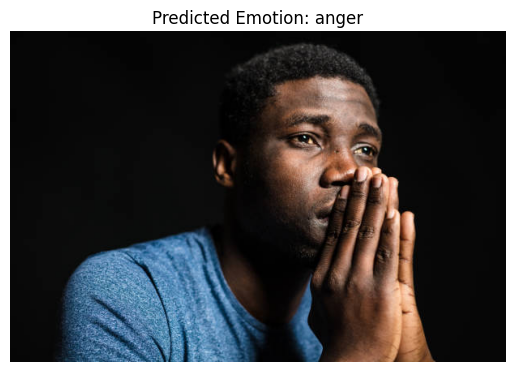

In [356]:
# Use the function to upload an image and get the prediction
upload_and_predict_emotion_ensemble(models)

Saving 360_F_122335513_GB4jSOLOix2BTYODKet4qWJH7AEaEszL.jpg to 360_F_122335513_GB4jSOLOix2BTYODKet4qWJH7AEaEszL (3).jpg
1/1 [==============================] - 0s 26ms/step
VGG16 Prediction: surprise
ResNet50 Prediction: surprise
InceptionV3 Prediction: happy
1/1 [==============================] - 0s 29ms/step
Ensemble Prediction: surprise


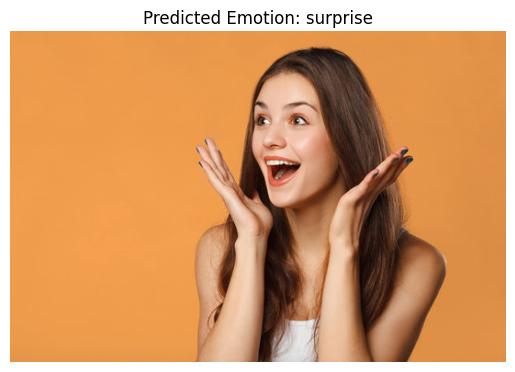

In [341]:
# Part 2
upload_and_predict_emotion_ensemble(models)